# Using bulk plasmons resonances to retrieve electronic parameters

The idea here is to show how, using the hydrodynamic model to fit the optical reflectance of a single highly doped semiconductor layer, all the electronic parameters can be retrieved at once. We will use standard libraries and PyMoosh, in which the hydrodynamic model has been implemented. In order to do so, we have to import the non-local part of the library, `PyMoosh.nonlocal`.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import PyMoosh as PM
from PyMoosh.non_local import *
# And just to have nice graphics
from matplotlib import rcParams
rcParams.update({
    "font.size": 12,
    "font.family": "serif",
    "axes.linewidth": 1,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "figure.dpi": 100,
})


## Experimental data & spectral range

We use an experimental spectrum stored in `h70_2.dat` (because, why not) and visualize it. We also choose which part of the spectrum is the most important -- where resonances can be seen. When the spectrum is uneventful, it has little importance and we know it is not well reproduced using a single incidence angle rather than an average over the angle. If there are too many points below the plasma frequency, the algorithm will focus on fitting this part, whereas the important part is above the (screened) plasma frequency.

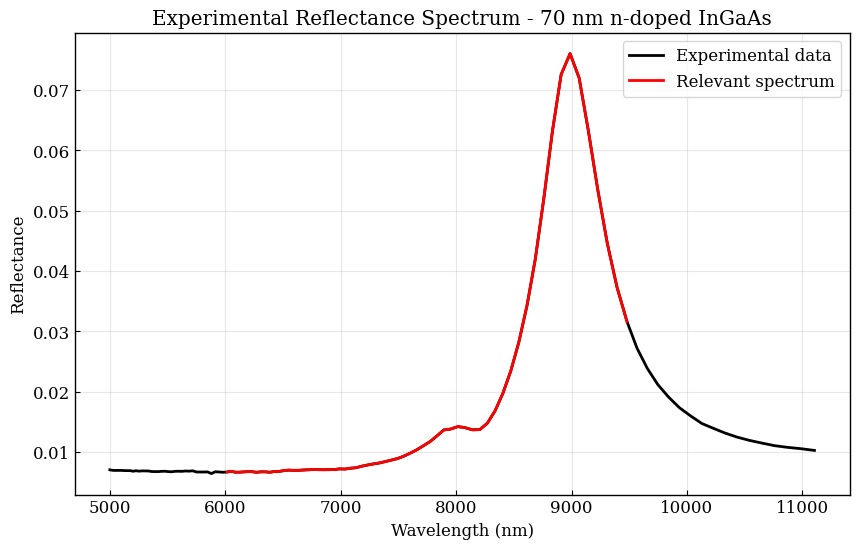

In [10]:
# Loading the data
data = np.loadtxt('h70_2.dat')
wavelength_exp = data[:, 0]
reflectance_exp = data[:, 1]

# Calling matplotlib to visualize everything.
plt.figure(figsize=(10, 6))
plt.plot(wavelength_exp, reflectance_exp, 'k-', linewidth=2, label='Experimental data')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Experimental Reflectance Spectrum - 70 nm n-doped InGaAs')
plt.grid(True, alpha=0.3)

# Restraining the data to the most important part where plasmon resonances can be seen
# This is important : the part below the plasma frequency bears no information and is
# not well reproduced when considering only one incidence angle.

lambda_min, lambda_max = 6000, 9500
mask = (wavelength_exp >= lambda_min) & (wavelength_exp <= lambda_max)
wavelength_exp = wavelength_exp[mask]
reflectance_exp = reflectance_exp[mask]
plt.plot(wavelength_exp, reflectance_exp, 'r', linewidth=2, label='Relevant spectrum')
plt.legend()
plt.show()


# Non-local material

We will here define our model for the doped semi-conductor. For a non-local material are expected : the $\beta^2$ parameter for the repulsion between electrons (or $\eta^2$ if it is complex, the imaginary part being associated to the second viscosity); $\chi_b$ the polarizability of the background; $\chi_f$ the polarizability associated to the electron gas (Drude model); $\omega_p$ the (true, not screened) plasma frequency.


In [12]:
# Parameters that are "global", because I'm lazy
h=70
thickness = [0,h,0]
# Incidence angle : we take the largest that is used experimentally, this is the one that contributes the most
# to the signal. 
theta = np.pi * 37 /180
# Of course the polarization is TM (pol = 1)
pol=1.

def sc_2ndviscosity(wavelength, chi_b, w_p, gamma, beta_0, tau):
    w = 2*np.pi*299792458*1e9 / wavelength
    eta2 = beta_0**2 - 1.0j * w * tau
    chi_f = - w_p**2/(w * (w + 1j * gamma))
# These are the parameters that are expected 
    return eta2, chi_b, chi_f, w_p


## Cost function

The cost function mesures the "distance" between the model and the experimental spectrum. It is not just a distance here. In order to help the algorithm feel statisfied when the global shape of the curves is the same (which means that the resonances are well placed and with the right profile) we use a cost function in two parts. One is strictly speaking the distance, the other is essentially the distance between the derivatives.


In [15]:
def cost_function(X):
    # Mapping : the mapping indicates to which element of X each parameters has to be associated.
    # I call it like this all the time. This is important. 
    chi_b, w_p, gamma, beta_0, tau, base, scale = X
    # We declare a nonlocal material. A bit weird way to do it, now that I think of it. 
    sc_nl = NLMaterial([sc_2ndviscosity, chi_b, w_p, gamma, beta_0, tau])
    # Number of wavelength considered in the spectrum. 
    nb_lam = len(wavelength_exp)
    
    # Now we define the structure with PyMoosh
    materials = [15.6816, sc_nl, 14.2129]
    stack = [0, 1, 2]
    # Thicknesses : the superstrate and substrate are assumed to be infinite, we put their thickness at 0. 
    # It could be anything.
    thickness = [0,h,0]
    # We declare the structure, as in normal PyMoosh, except for the name of the functions
    thing = NLStructure(materials,stack,thickness,verbose=False)

    # We compute the spectrum corresponding to vector X. That is where `scale` and `base` are used.
    #new_wl = wavelength_exp
    R=np.zeros(nb_lam)
    for k in range(nb_lam):
        _,_,R[k],_ = NLcoefficient(thing,wavelength_exp[k],np.pi * 37 / 180,1.0)
    R = R*scale + base
    
    # And now the computation of the cost function, for real. 
    cost = np.mean(np.abs(R - reflectance_exp))+nb_lam*np.mean(np.abs(np.diff(R)-np.diff(reflectance_exp)))
    return cost


# Running the optimization

Now we just have to run the optimization. In order to do so, we define an optimization domain by settings bounds on each of the parameters. For many parameters, since we do not have a precise idea, the allowed interval is rather large. For others, not. For instance, we assume that the background permittivity is not much changed by the doping, which is reasonable. This is a relatively important assumption. While we do not fully trust the value given by experiments on the undoped material, well we leave a restrained interval. 

Then we just launch the algorithm, and retrieve the vector corresponding to the best fit, as well as the convergence curve ! This is the part that takes time... 

In [16]:
X_min = np.array([11.6,4e14,0.1e13,7.5e14,1e14,0.0,0.01])
X_max = np.array([11.7,12e14,1.5e13,10e14,1.2e15,0.2,2.])
best , convergence = PM.QODE(cost_function,10000,X_min,X_max,progression=10)


Progression : 10.03%. Current best cost : 0.02179
Progression : 20.06%. Current best cost : 0.018721
Progression : 30.09%. Current best cost : 0.016487
Progression : 40.12%. Current best cost : 0.015355
Progression : 50.15%. Current best cost : 0.014949
Progression : 60.18%. Current best cost : 0.01482
Progression : 70.21%. Current best cost : 0.014785
Progression : 80.24%. Current best cost : 0.014743
Progression : 90.27%. Current best cost : 0.014743


# Extraction

I call the last part the extraction, I do not know exactly why.  Firt, we have a look at the convergence curve, to see it there is the slightest clue that the optimization has not really converged. Well the values shown above indicate already that the budget (10000 computations of the cost function) seems sufficient.

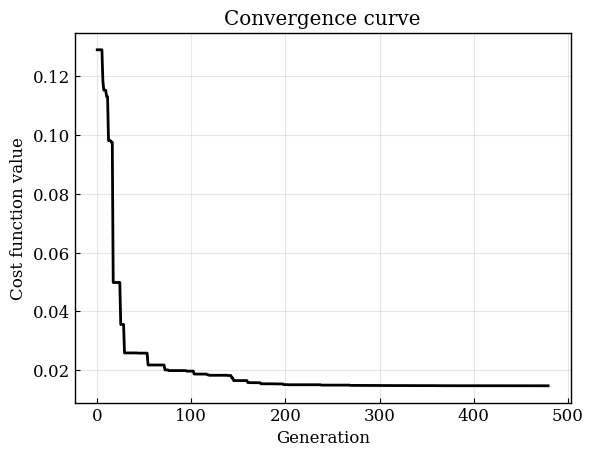

In [18]:
plt.plot(convergence, 'k-', linewidth=2)
plt.xlabel('Generation')
plt.ylabel('Cost function value')
plt.title('Convergence curve')
plt.grid(True, alpha=0.3)


You need to make sure the result you have is indeed satisfactory. We will simply plot the experimental spectrum along with the simulated spectrum to see how well they fit.

List of materials:
Simple, non dispersive: epsilon= (15.6816+0j)
Material: NLMaterial
Simple, non dispersive: epsilon= (14.2129+0j)


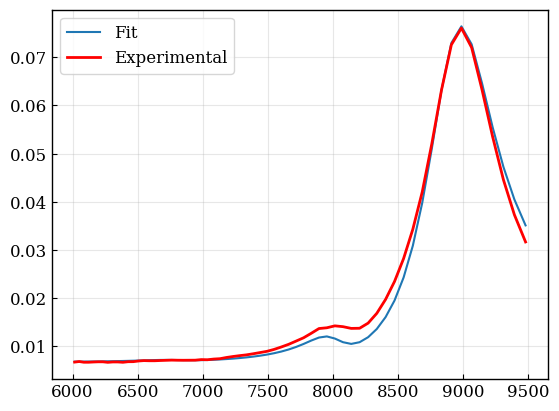

In [20]:
# We retrieve the parameters from the optimization results (mapping !)
chi_b, w_p, gamma, beta_0, tau, base, scale = best
# We compute the spectrum as in the cost function 
nSC_2nd = NLMaterial([sc_2ndviscosity,chi_b, w_p, gamma, beta_0, tau])
optimized_nl = NLStructure([15.6816, nSC_2nd, 14.2129],[0,1,2],thickness)
R_optim = []
for wl in wavelength_exp:
    _,_,R,_ = NLcoefficient(optimized_nl,wl,theta,1.)
    R_optim.append(R)
R=np.array(R_optim)
R = R*scale+base
plt.plot(wavelength_exp,R,label="Fit")
plt.plot(wavelength_exp, reflectance_exp, 'r', linewidth=2, label='Experimental')
plt.plot()
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
